In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from keras_ssd7 import build_model
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

Using TensorFlow backend.


In [2]:
img_height = 300 # 图片长度
img_width = 400 # 图片宽度
img_channels = 3 # 图片通道书
n_classes = 2 # 待分类类别数
min_scale = 0.08 
max_scale = 0.96 
scales = [0.08, 0.16, 0.32, 0.64, 0.96] 
aspect_ratios = [0.5, 1.0, 2.0] 
two_boxes_for_ar1 = True 
limit_boxes = False 
variances = [1.0, 1.0, 1.0, 1.0] 
coords = 'centroids' 
normalize_coords = False 
predictor_sizes = [[35, 58], 
                   [16, 28],
                   [ 7, 13],
                   [ 2,  5]]

In [ ]:
# 1: 新建立模型

K.clear_session() 

model, predictor_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                     n_classes=n_classes,
                                     min_scale=min_scale,
                                     max_scale=max_scale,
                                     scales=scales,
                                     aspect_ratios_global=aspect_ratios,
                                     aspect_ratios_per_layer=None,
                                     two_boxes_for_ar1=two_boxes_for_ar1,
                                     limit_boxes=limit_boxes,
                                     variances=variances,
                                     coords=coords,
                                     normalize_coords=normalize_coords)

# 2: 装载以保存的权重

model.load_weights('D:/GitHub/ssd_keras/ssd7_weights.h5')

# 3: 设置优化函数和损失函数

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04) 

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [3]:
# or装载以保存的模型
model_path = 'ssd7.h5'

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() 

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

In [4]:
# 1: 建立数据集格式
train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])
val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

In [5]:
# 2: 设置数据集的路径

train_images_path = 'D:/big_sign_dataset/img_300p/'
train_labels_path = 'D:/big_sign_dataset/train_labels_300p.csv'


val_images_path = 'D:/big_sign_dataset/img_300p/'
val_labels_path = 'D:/big_sign_dataset/val_labels_300p.csv'

train_dataset.parse_csv(images_path=train_images_path,
                        labels_path=train_labels_path,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_path=val_images_path,
                      labels_path=val_labels_path,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

In [6]:

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 4: 设置数据包大小，装满GPU为准
batch_size = 32 

# 5: 装载训练集测试集
train_generator = train_dataset.generate(batch_size=batch_size,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5), 
                                         flip=0.5, 
                                         translate=((5, 50), (3, 30), 0.5), 
                                         scale=(0.75, 1.3, 0.5), 
                                         max_crop_and_resize=False,
                                         full_crop_and_resize=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=False,
                                     full_crop_and_resize=False,
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4,
                                     diagnostics=False)

n_train_samples = train_dataset.get_n_samples()
n_val_samples = val_dataset.get_n_samples()

In [ ]:
# 开始训练：设置训练epochs.
epochs = 40

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('ssd7_weights_epoch-{epoch:02d}_loss-{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=2),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

model_name = 'ssd7'
model.save('{}.h5'.format(model_name))
model.save_weights('{}_weights.h5'.format(model_name))

print()
print("Model saved under {}.h5".format(model_name))
print("Weights also saved separately under {}_weights.h5".format(model_name))
print()

In [7]:
### 开始预测


predict_generator = val_dataset.generate(batch_size=1,
                                         train=False,
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         max_crop_and_resize=False,
                                         full_crop_and_resize=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)

In [31]:
# 2: 随机选取样本

X, y_true, filenames = next(predict_generator)

i = 0 

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

Image: D:/big_sign_dataset/img_300p/03576.jpg

Ground truth boxes:

[[  1 159 167 145 147]]


In [28]:
# 3: 预测

y_pred = model.predict(X)

In [29]:
# 4: 重编译输出值，方便绘图

y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.5,
                           iou_threshold=0.4,
                           top_k='all',
                           input_coords='centroids',
                           normalize_coords=False,
                           img_height=None,
                           img_width=None)

print("Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):\n")
print(y_pred_decoded[i])

Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):

[[   1.            0.98915207  211.80206299  235.54083252  104.9752121
   121.91764069]
 [   1.            0.96773148  201.38554382  240.00819397  109.18792725
   129.40342712]
 [   1.            0.96162897  204.85108948  225.70237732  109.03488159
   123.68699646]
 [   1.            0.51409769  225.87368774  245.33078003  105.33192444
   126.64143372]]


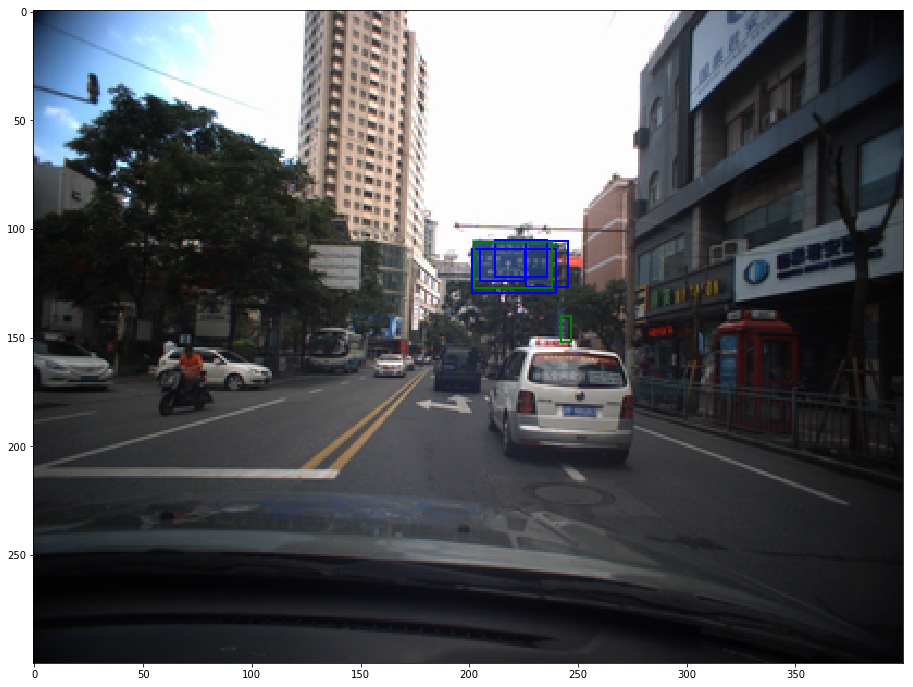

In [30]:
plt.figure(figsize=(20,12))
plt.imshow(X[i])

current_axis = plt.gca()

classes = ['background', 'big_sign'] 

# 画预测框
for box in y_pred_decoded[i]:
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((box[2], box[4]), box[3]-box[2], box[5]-box[4], color='blue', fill=False, linewidth=2))  
    #current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':0.5})

# 画原有的标签框
for box in y_true[i]:
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((box[1], box[3]), box[2]-box[1], box[4]-box[3], color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})